In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# Trend Indicator Analysis and Implementation
## 1. Introduction
The goal of this report is to analyze and implement a trend indicator methodology based on exponentially weighted moving averages (EWMA). This indicator is derived from a referenced methodology and is designed to dynamically assess market trends based on historical price data. The implementation and analysis include:

* Dynamic trend detection.
* Visualization of price trends with color-coded segments.
* Application of the methodology using Python.
* Backtesting a trading strategy based on the indicator.

The implementation is referenced from the document titled "Trend Indicator Methodology," which outlines the mathematical foundation and parameters for the trend indicator.

## 2. Methodology

### 2.1 Exponentially Weighted Moving Average (EWMA)
The Trend Indicator is based on the EWMA calculation, which is computed for different half-lives to capture short-term and long-term trends. The decay factor $\lambda_h$ for each half-life $h$  is calculated as:
$$\lambda_h=e^{-ln(2)/h}$$
The normalization factor $NF_{h}$ ensures that the weights of the EWMA sum to 1 over the given period of 180 days.

### 2.2 Trend Detection

The methodology uses four pairs of short-term and long-term EWMA comparisons:

|Pair|Short-Term Half-Life|Long-Term Half-Life|
|:-:|:-:|:-:|
|1|1 day|5 days|
|2|2.5 days|10 days|
|3|5 days|20 days|
|4|10 days|40 days|

For each pair, the trend is determined as:
$$MAP_t=SIGN(MA_{short,t}-MA_{long,t})$$
The final trend indicator is the average of these four pairs:
$$TI_{t}=\frac{1}{4}(MAP_1+MAP_2+MAP_3+MAP_4)$$

### 2.3 Visualization

The trend indicator is used to generate a color-coded plot of historical price data. Each segment of the line is colored based on the value of the trend indicator, providing a clear visual representation of market trends.

## 3. Python Implementation

### 3.1 Code for EWMA Calculation and Trend Indicator

In [8]:
import numpy as np
import pandas as pd


btc_price = yf.download('BTC-USD', start='2018-01-01', end='2024-05-01')
btc_price = btc_price.rename(columns={'Close':'Price'})

# Half-life decay factors
decay_factors = {
    1: 0.5,
    2.5: 0.757858283,
    5: 0.870550563,
    10: 0.933032992,
    20: 0.965936329,
    40: 0.982820599
}

# Compute Exponentially Weighted Moving Averages (EWMA)
def ewma(series, half_life):
    decay = decay_factors[half_life]
    weights = np.array([(1 - decay) * (decay ** i) for i in range(len(series))])
    weights /= weights.sum()  # Normalize weights
    return np.dot(weights, series[::-1])

# Compute moving averages for each half-life
for h in [1, 2.5, 5, 10, 20, 40]:
    btc_price[f"MA_{h}"] = btc_price['Price'].rolling(window=180, min_periods=1).apply(lambda x: ewma(x, h), raw=True)

# Compute Trend Indicator components
btc_price["MAP1"] = np.sign(btc_price["MA_1"] - btc_price["MA_5"])
btc_price["MAP2"] = np.sign(btc_price["MA_2.5"] - btc_price["MA_10"])
btc_price["MAP3"] = np.sign(btc_price["MA_5"] - btc_price["MA_20"])
btc_price["MAP4"] = np.sign(btc_price["MA_10"] - btc_price["MA_40"])

# Compute Final Trend Indicator
btc_price["Trend_Indicator"] = (btc_price["MAP1"] + btc_price["MAP2"] + btc_price["MAP3"] + btc_price["MAP4"]) / 4

# Display last 10 values
print(btc_price[['Price', 'Trend_Indicator']].tail(10))

[*********************100%%**********************]  1 of 1 completed


                   Price  Trend_Indicator
Date                                     
2024-04-21  64926.644531              0.0
2024-04-22  66837.679688              0.5
2024-04-23  66407.273438              0.5
2024-04-24  64276.898438              0.0
2024-04-25  64481.707031              0.0
2024-04-26  63755.320312              0.0
2024-04-27  63419.140625              0.0
2024-04-28  63113.230469              0.0
2024-04-29  63841.121094              0.0
2024-04-30  60636.855469              0.0


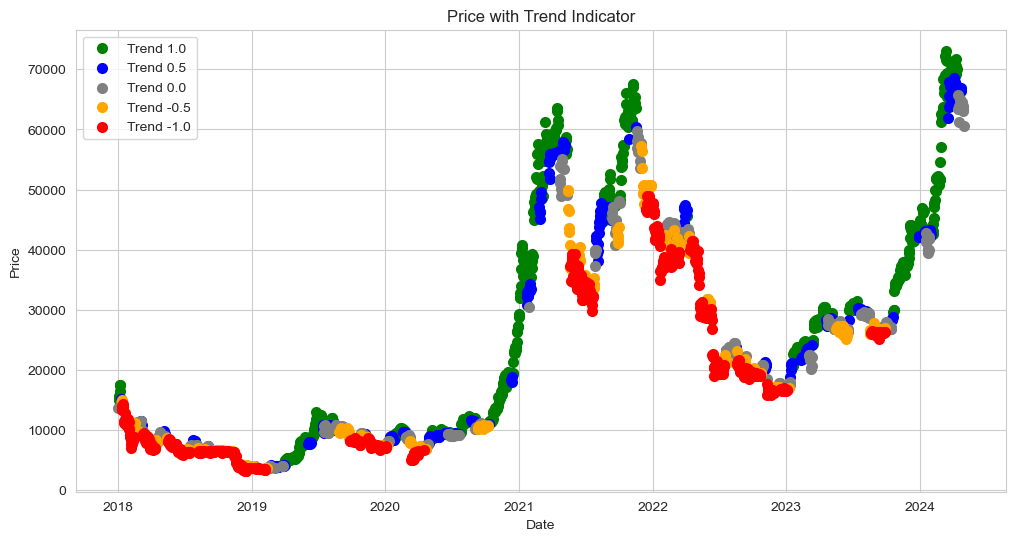

In [9]:
# Define color mapping based on Trend Indicator values
color_map = {
    1.0: 'green',   # Strong uptrend
    0.5: 'blue',    # Uptrend
    0.0: 'gray',    # No trend
    -0.5: 'orange', # Downtrend
    -1.0: 'red'     # Strong downtrend
}

# Plot the price with color-coded Trend Indicator
plt.figure(figsize=(12, 6))
for trend_value, color in color_map.items():
    trend_data = btc_price[btc_price['Trend_Indicator'] == trend_value]
    plt.scatter(trend_data.index, trend_data['Price'], label=f"Trend {trend_value}", color=color, linewidth=2)

# Add labels, title, and legend
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price with Trend Indicator")
plt.legend()
plt.grid(True)
plt.show()

### 3.2 Backtesting Strategy
The following strategy uses the Trend Indicator to determine buy and sell signals:

#### Strategy Rules:
- **Long Position**: Enter when `Trend_Indicator >= 1`.
- **Short Position**: Enter when `Trend_Indicator <= -1`.
- **Hold Cash**: When `Trend_Indicator` is neutral (e.g., between -1 and 1).

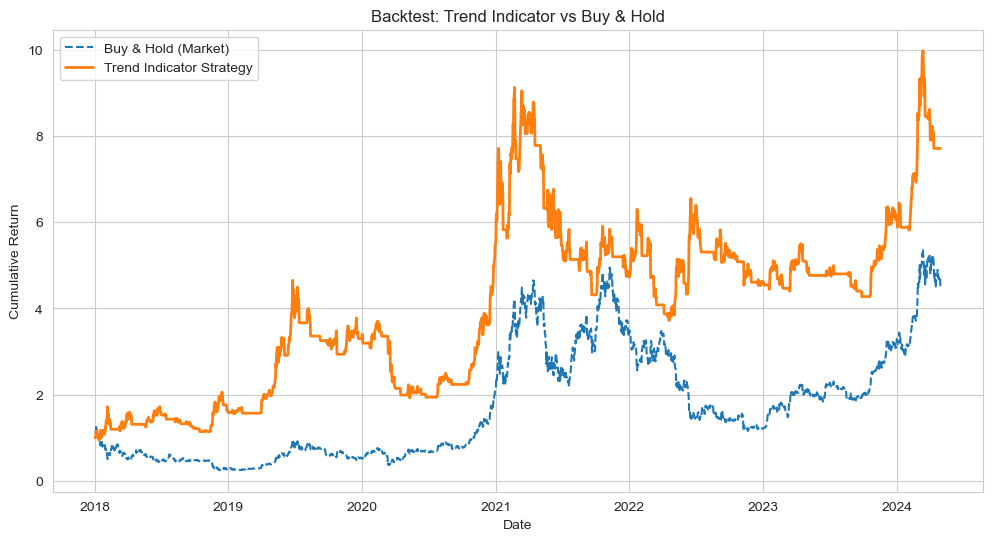

Sharpe Ratio (Strategy): 0.67
Sharpe Ratio (Market): 0.54
Max Drawdown (Strategy): -59.23%
Max Drawdown (Market): -81.53%


In [10]:
# Define Trading Strategy
btc_price["Position"] = 0
btc_price.loc[btc_price["Trend_Indicator"] >= 1, "Position"] = 1  # Long when indicator >= 0.5
btc_price.loc[btc_price["Trend_Indicator"] <= -1, "Position"] = -1 # Short when indicator <= -0.5
btc_price["Position"] = btc_price["Position"].shift(1)  # Avoid lookahead bias

# Compute Daily Returns
btc_price["Market_Return"] = btc_price["Price"].pct_change()
btc_price["Strategy_Return"] = btc_price["Position"] * btc_price["Market_Return"]

# Compute Cumulative Returns
btc_price["Cumulative_Market"] = (1 + btc_price["Market_Return"]).cumprod()
btc_price["Cumulative_Strategy"] = (1 + btc_price["Strategy_Return"]).cumprod()

# Compute Sharpe Ratio (Risk-Adjusted Return)
def sharpe_ratio(returns, risk_free_rate=0.02, trading_days=252):
    excess_returns = returns - risk_free_rate / trading_days
    return np.sqrt(trading_days) * excess_returns.mean() / returns.std()

sharpe_strategy = sharpe_ratio(btc_price["Strategy_Return"].dropna())
sharpe_market = sharpe_ratio(btc_price["Market_Return"].dropna())

# Compute Maximum Drawdown
def max_drawdown(cumulative_returns):
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

max_dd_strategy = max_drawdown(btc_price["Cumulative_Strategy"])
max_dd_market = max_drawdown(btc_price["Cumulative_Market"])

# Plot Performance Comparison
plt.figure(figsize=(12,6))
plt.plot(btc_price.index, btc_price["Cumulative_Market"], label="Buy & Hold (Market)", linestyle="--")
plt.plot(btc_price.index, btc_price["Cumulative_Strategy"], label="Trend Indicator Strategy", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.title("Backtest: Trend Indicator vs Buy & Hold")
plt.show()

# Print Results
print(f"Sharpe Ratio (Strategy): {sharpe_strategy:.2f}")
print(f"Sharpe Ratio (Market): {sharpe_market:.2f}")
print(f"Max Drawdown (Strategy): {max_dd_strategy:.2%}")
print(f"Max Drawdown (Market): {max_dd_market:.2%}")

### 3.3 Backtest Results
The backtest results demonstrate the performance of the strategy:

| **Metric**       | **Strategy** | **Market (Buy & Hold)** |
|:-:|:-:|:-:|
| **Sharpe Ratio** | 0.67         | 0.54                     |
| **Max Drawdown** | -59.23%      | -81.53%                  |

### 3.4 Observations
* The **Sharpe Ratio** of the strategy indicates better risk-adjusted returns compared to the market.
* The strategy significantly reduces **Maximum Drawdown**, showing lower risk during market downturns.

## 4. Reference
This implementation is based on the "Trend Indicator Methodology" document provided, which details the calculation of EWMA, decay factors, normalization factors, and the overall trend detection framework.
https://indices.coindesk.com/indices/trend-indicators